# Final Project: Telecom Interconnect

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts. Our goal is to develop a model with an AUC-ROC score of at least .88. We'll perform exploratory data analysis and preprocessing, ensuring our data is suitable for classification and removing unnecessary features while creating new ones. We'll traina and test various classification models, including singular gradient-boosting models and ensemble models using blending and stacking techniques. Finally, we'll identify and describe our best performning model, which will be submitted as partial fulfillment of the project criteria.

Due to an unexpected GPU error, I could not go forward with the original project plan so I revised a new plan below and it worked out good too.

# Project Plan (Revised)

1. Exploratory Data Analysis:
- Contract data
- Personal data
- Internet data
- Phone data
- Combined Dataframe EDA
 
2. Prepare Data For Model Training:
- Drop fields not required for model training.
- Encode categorical fields
- Split data into training, validation and test sets
- Perform scalling
- Print shape of training sets

3. Tune & Evaluate Classification Models on Training Data:
- DummyClassifier Baseline
- LogisticRegression
- Model Evaluation Function
- RandomForestClassifier
- LGBMClassifier
- CatBoostClassifier
- XGBClassifier

4. Choose Model & Evaluate Performance on Test Data:
- DummyClassifier Baseline for Test Data Evalutation
- XGBClassifier for Test Data Evaluation

5. Conclusion

# Import Libraries

In [1]:
# Import libraries required for this analysis
import numpy as np
import pandas as pd

# For displaying images 
import matplotlib.pyplot as plt

# For Train, Test, Split
from sklearn.model_selection import train_test_split

# For Scaling
from sklearn.preprocessing import StandardScaler

# Grid Search
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

# Accuracy score libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

# From sklearn get classification models, model evaluation packages, and training data split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# https://lightgbm.readthedocs.io/en/stable/Python-Intro.html
from lightgbm import LGBMClassifier

# https://catboost.ai/en/docs/concepts/python-usages-examples
from catboost import CatBoostClassifier

#https://xgboost.readthedocs.io/en/stable/python/python_api.html
from xgboost import XGBClassifier

# Display all fields
pd.set_option('display.max_columns', None)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load Data

The data comprises files sourced from various sources, including:

- contract.csv: Contains contract information.
- personal.csv: Holds the client’s personal data.
- internet.csv: Provides information about internet services.
- phone.csv: Offers details about telephone services.

In [2]:
# Read in data CSVs and convert to dataframes

# Contract
contract = pd.read_csv('/datasets/final_provider/contract.csv')

# Personal
personal = pd.read_csv('/datasets/final_provider/personal.csv')

# Internet
internet = pd.read_csv('/datasets/final_provider/internet.csv')

# Phone
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
# Create a function to look at descriptive stats for each dataframe
def descriptive_stats(df):
    
    # Print dataframe
    print('Sample of dataframe')
    display(df.head())
    print()
    
    # Check for missing values
    print('Check for Missing Values')
    print(df.isna().sum())
    print()

    # Check data types
    print('Check Data Types')
    print(df.info())
    print()

    # Check values for each column
    print('Describe Dataframe')
    print(df.describe(include = 'all'))
    print()
    
    # Check for Duplicates
    print('Count of Duplicated Rows')
    print(df.duplicated().sum())

# EDA for Contract

In [4]:
# Check descriptive_stats for contract
descriptive_stats(contract)

Sample of dataframe


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



Check for Missing Values
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Check Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Describe Dataframe
        customerID   BeginDate EndDate            Type PaperlessBilling  \
count         7043        7043    704

Fix Fields & Create New Features

In the following cells, I’ll perform a few tasks:

- When the EndDate field is filled with ‘No’, replace it with 0. Otherwise, replace it with 1. This will indicate whether the user churned or not, which will serve as our target variable.
- Convert the BeginDate field to a datetime format.
- Create a new field called EndDate_New, which will replace ‘No’ with 2/1/2020. This will allow us to calculate the months between BeginDate and EndDate_New, which can be used as a feature to train the model.
- Convert the TotalCharges field to a float.
- Investigate why the TotalCharges field was initially ingested as an object and explore and correct the issue.

In [5]:
# For getting a rough sense of how churned an non-churned customers differ, I want to plot features by churn and did not churn
contract['Churned'] = np.where(contract['EndDate'] == 'No', 0, 1)

In [6]:
# Convert BeginDate to datetime
contract['BeginDate'] = contract['BeginDate'].apply(pd.to_datetime)

In [7]:
# In order to calculate the difference in months between we need to create a new field called EndDate_New
# If the user hasn't churned I will use the validation date for the contracts which is 2/1/2020
contract['EndDate_New'] = np.where(contract['EndDate'] == 'No', '2020-02-01', contract['EndDate'])
contract['EndDate_New'] = contract['EndDate_New'].apply(pd.to_datetime)

# Calculate differnce in months between EndDate_New and BeginDate
contract['months_diff'] = ((contract['EndDate_New'] - contract['BeginDate'])/np.timedelta64(1, 'M'))
contract['months_diff'] = contract['months_diff'].astype(int)

# Print df info to see if fields are correct type
contract.info()

# Display df sample
display(contract.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   Churned           7043 non-null   int64         
 9   EndDate_New       7043 non-null   datetime64[ns]
 10  months_diff       7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 605.4+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churned,EndDate_New,months_diff
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,2020-02-01,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0,2020-02-01,34
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,2019-12-01,2
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,2020-02-01,45
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,2019-11-01,2


In [8]:
# Convert TotalCharges to float
# When converting TotalCharges to float the cell raised and error because there were strings in the field
# They don't have a total charge because they signed up in the same month the data was pulled 

# Look at total charges with no value
display(contract[contract['TotalCharges'] == ' '])

# I found that there were values = '0'. For these values I am replacing them with MonthlyCharges
contract['TotalCharges'] = np.where(contract['TotalCharges'] == ' ', contract['MonthlyCharges'], contract['TotalCharges'])

# Convert TotalCharges to float after replacing ' ' values
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churned,EndDate_New,months_diff
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0,2020-02-01,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0,2020-02-01,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0,2020-02-01,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,0,2020-02-01,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0,2020-02-01,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,0,2020-02-01,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,0,2020-02-01,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,0,2020-02-01,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,0,2020-02-01,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,0,2020-02-01,0


In [9]:
# Count of customers that chruned vs those who didn't churn
contract.groupby('Churned').agg({'customerID': 'count'})

,customerID
Churned,
0,5174
1,1869


The data set contains 1869 users who have churned, which represents approximately 27% of the user base.

In the following cells, I’ll investigate if there are any visual differences between churned and non-churned users for numerical fields. I’ve created a function that generates an output for each numerical field, displaying the count of users per feature.

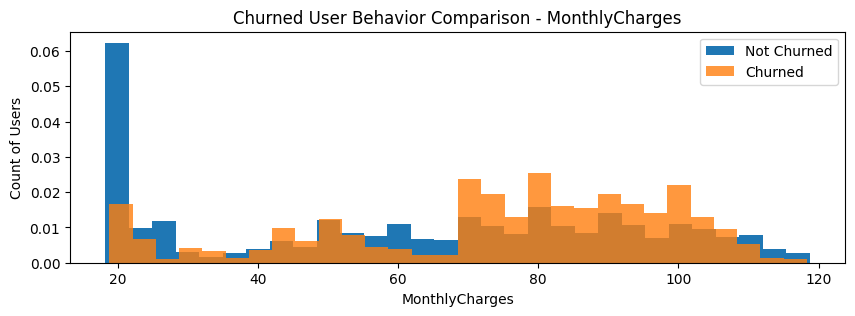

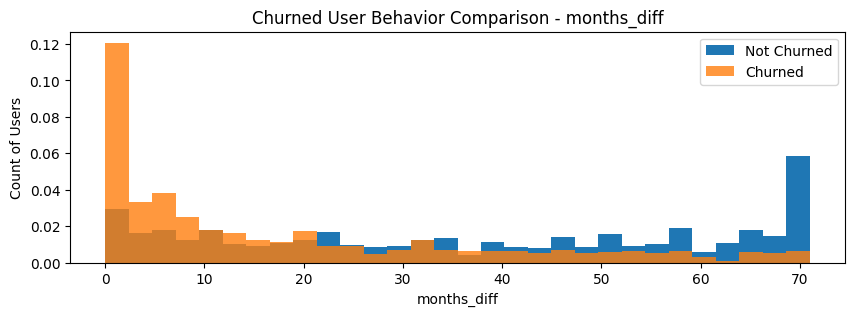

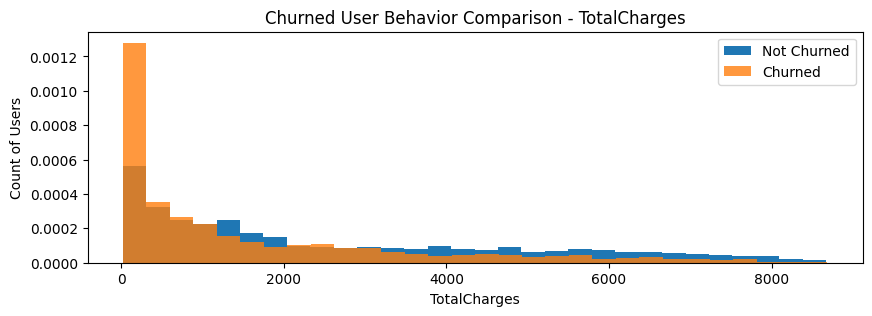

In [10]:
# Generate a histogram for each user group using the fields that are passed in to the function
def generate_histogram(df, attributes):
    for a in attributes:
    
        # Non-Churned users 
        df[df['Churned'] == 0][a].plot(kind='hist', bins=30, figsize=(10,3), density=True)

        # Churned users 
        df[df['Churned'] == 1][a].plot(kind='hist', bins=30, alpha=0.8, figsize=(10,3), density=True)

        # Set legend values
        plt.legend(['Not Churned', 'Churned'])

        # Set Axis and Title
        plt.xlabel(a)
        plt.ylabel('Count of Users')
        plt.title(f"Churned User Behavior Comparison - {a}")

        # Plot Histogram
        plt.show()
        
# Create list of features with numerical datatypes
attributes = ['MonthlyCharges','months_diff','TotalCharges']

# Run function
generate_histogram(contract, attributes)


Compared to users who haven’t churned, churned users have higher monthly charges and stay with Interconnect for a shorter duration. However, it’s not possible to draw conclusions about Total Charges because it’s a product of monthly charges and the duration spent with Interconnect.

# Bar Plot For Plotting Numerical Data For Churned Versus Non-Churned Users

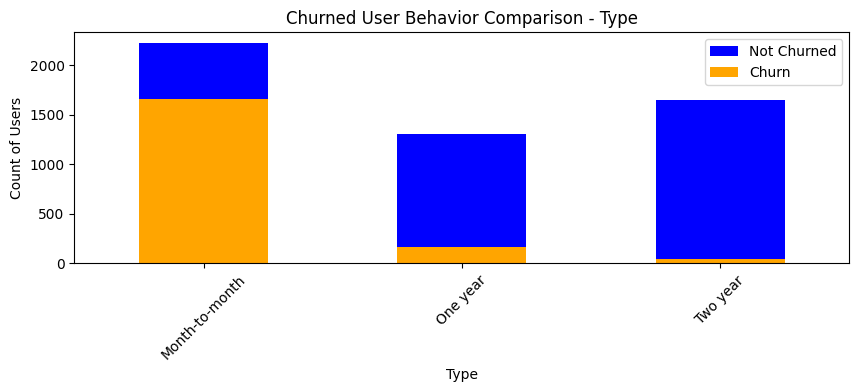

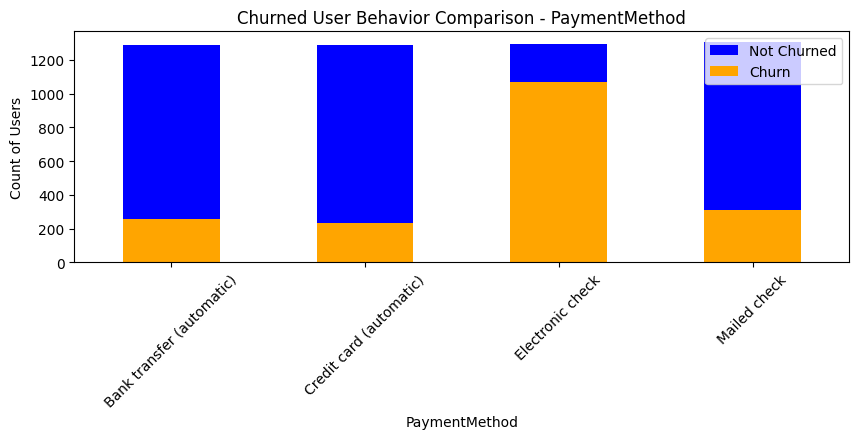

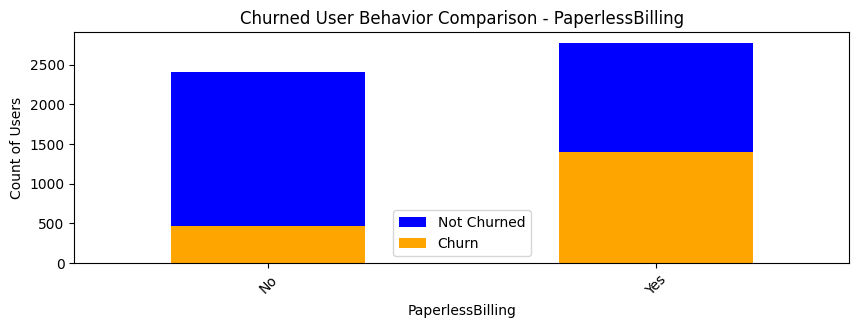

In [11]:
# Generate a histogram for each user group using the fields that are passed in to the function
def bar_plots(df, attributes):
    for a in attributes:
        
        # Pivot df into a format usable with bar plot
        table = pd.pivot_table(df, values='customerID', index=a,
                               columns='Churned', aggfunc="count")

        # Non-Churned users 
        no_churn = table[0].to_frame(name="vals").reset_index()
        
        # Churned users 
        churn = table[1].to_frame(name="vals").reset_index()

        # Plot Histogram on same plot
        ax = no_churn.plot(kind='bar', x=a, y = 'vals' , color ='blue', figsize=(10,3),stacked = 'False',rot=45)
        churn.plot(ax=ax,kind='bar', x=a, y = 'vals' , color ='orange', figsize=(10,3), stacked = 'False',rot=45)

        # Set legend values
        plt.legend(['Not Churned', 'Churn'])

        # Set Axis and Title
        plt.xlabel(a)
        plt.ylabel('Count of Users')
        plt.title(f"Churned User Behavior Comparison - {a}")
 
# Create list of features with categorical datatypes
attributes = ['Type','PaymentMethod','PaperlessBilling']

# Run function
bar_plots(contract, attributes)

Compared to users who haven’t churned, churned users are more likely to be on month-to-month contracts, use electronic checks as their payment method, and opt for paperless billing.

Contract EDA Conclusions:

- Created a field called Churned, with 0 for users who didn’t churn and 1 for those who did.
- Converted BeginDate to EndDate to datetime and TotalCharges to float.
- Created a field called MonthsElapsed, which will be used as a feature in model training.
- Subtracted months from the start date to the churn date. If a user didn’t churn, use February 1, 2020, as the churn date (the date the contract information was validated).
- There are 1869 users in the dataset who have churned, which represents approximately 27% of the user base.
- Compared to users who haven’t churned, churned users have higher monthly charges and are with Interconnect for a shorter period of time than non-churned users. However, it’s important to note that TotalCharges can’t be directly drawn from this comparison because it’s a function of both monthly charges and the duration spent with Interconnect.
- Compared to users who haven’t churned, churned users are more likely to be in month-to-month contracts, use electronic check as their payment method, and use paperless billing.

In [12]:
# Check descriptive_stats for contract
descriptive_stats(personal)

Sample of dataframe


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Check for Missing Values
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Check Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Describe Dataframe
        customerID gender  SeniorCitizen Partner Dependents
count         7043   7043    7043.000000    7043       7043
unique        7043      2            NaN       2          2
top     3315-TOTBP   Male            NaN      No         No
freq             1   3555            NaN    3641       4933
mean           NaN    NaN       0.162147     NaN        NaN
std 

Personal EDA Conclusions

There are no duplicated rows or missing values in the Personal dataframe. None of the data types require conversion, and no additional features need to be created for this dataframe.

In a subsequent section, I will join the Personal dataframe with the Contract dataframe. The Personal dataframe lacks information about user churn, so I need to retrieve this field from the Contract dataframe to derive insights into churn based on personal information such as gender or age (SeniorCitizen).

# EDA for Internet

In [13]:
# Check descriptive_stats for contract
descriptive_stats(internet)

Sample of dataframe


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Check for Missing Values
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Check Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Describe Dataframe
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
un

Internet EDA Conclusions

- There are no duplicated rows or missing values. None of the datatypes need to be converted. No additional features need to be created for this dataframe.
- There are only 5517 entries in this dataframe where as both the personal and the contract dataframes have 7043 entries.
- Why are there less rows in this table? Is it because not all users are enrolled for internet?
- There are two choices for internet - DSL and Fiber Optic.
- All other columns in this dataframe have values of yes or no. I can use OHE on fields at a later stage when I am preparing my data for model training.
- In a later section, I will left join the Internet dataframe to the Contract dataframe on customerID. Internet dataframe doesn't contain information about whether the user churned or not, so I need to get this field from Contract so that I can derive insights about churn based on internet plan information.

# EDA for Phone

In [14]:
# Check descriptive_stats for contract
descriptive_stats(phone)

Sample of dataframe


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Check for Missing Values
customerID       0
MultipleLines    0
dtype: int64

Check Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Describe Dataframe
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5183-SNMJQ            No
freq             1          3390

Count of Duplicated Rows
0


Phone EDA Conclusions

- The phone dataframe is clean and free of duplicates or missing values. No data type conversions or feature creation are required.

- However, there’s a discrepancy in the number of entries. The phone dataframe has only 6361 entries, while both the personal and contract dataframes have 7043 entries. This raises the question of why there are fewer rows in the phone dataframe. Could it be that not all users are enrolled for internet services?

- The internet dataframe offers two options: DSL and Fiber Optic. All other columns in the phone dataframe have values of yes or no. I can consider using One-Hot Encoding (OHE) on these fields later when preparing my data for model training.

- In a subsequent section, I’ll perform a left join between the internet dataframe and the contract dataframe on the customerID column. The internet dataframe lacks information about user churn, so I’ll need to retrieve this field from the contract dataframe to gain insights into churn based on internet plan information.

Merge Dataframe & Data Cleansing

All four dataframes contain crucial information about users who churn and those who don’t. However, only the contract dataframe provides information on whether a user has churned or not. Therefore, we need to combine these four dataframes into one using the customerID as the key. In this section, I will join all four dataframes into one. Subsequently, I will clean the data after the join. Finally, I will present an Exploratory Data Analysis (EDA) on the combined dataframe.

In [15]:
# Join contract to personal on customerID
tele = contract.merge(personal, how = 'inner', on = 'customerID')

# Join data to internet on customerID
tele = tele.merge(internet, how = 'left', on = 'customerID')

# Join data to phone on customerID
tele = tele.merge(phone, how = 'left', on = 'customerID')

# Check to ensure that no rows were lost in the joins
print('Contract Rows -', contract.shape[0])
print('Data Rows -', tele.shape[0])

Contract Rows - 7043
Data Rows - 7043


In [16]:
#Check Resulting Dataframe
descriptive_stats(tele)

Sample of dataframe


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churned,EndDate_New,months_diff,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,2020-02-01,1,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,2020-02-01,34,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,2019-12-01,2,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,2020-02-01,45,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,2019-11-01,2,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No



Check for Missing Values
customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churned                0
EndDate_New            0
months_diff            0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Check Data Types
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object

# Cleaning Data

In [17]:
# If user has a null value for MultipleLines this means that the user doesn't have phone 
# Create new field called HasPhone - 0 if MultipleLines is null, else 1
tele['HasPhone'] = tele['MultipleLines'].notnull().astype(int)

In [18]:
# If user has a null value for InternetService this means that the user doesn't have internet
# Create new field called HasInternet - 0 if InternetService is null, else 1
tele['HasInternet'] = tele['InternetService'].notnull().astype(int)

In [19]:
# Service start day of week
tele['start_day'] = tele['BeginDate'].dt.dayofweek

# Service start month
tele['start_month'] = tele['BeginDate'].dt.month

# Service start year
tele['start_year'] = tele['BeginDate'].dt.year

Replacing Missing Values Due to Phone and Internet Left Joins

Not all users with a contract have both phone and internet service. For instance, if a user lacks internet but has phone service, the customer will have null values for internet-related fields. To address these null values, we need to replace them with a suitable value. I’ll replace null values with the string ’N/A’ because these fields are not relevant to the user without the service.

In [20]:
# Check which fields have missing values first
print('Check For Missing Values Before Fill')
print(tele.isna().sum())
print()

# Replace missing values with 'N/A'
tele = tele.fillna('N/A')

# Check that missing values have been replaced
print('Check For Missing Values After Fill')
print(tele.isna().sum())
print()

Check For Missing Values Before Fill
customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churned                0
EndDate_New            0
months_diff            0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
HasPhone               0
HasInternet            0
start_day              0
start_month            0
start_year             0
dtype: int64

Check For Missing Values After Fill
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churned             0
EndDate_New    

Now that there are no longer missing values and we’ve verified that we didn’t drop any rows due to the joins of each dataframe, we can proceed with exploratory data analysis (EDA) on the combined dataframe. I’ll utilize the same visualization function I employed earlier to plot numerical and categorical fields, enabling us to analyze the differences between users who churned and those who didn’t.

In [21]:
# Check datatypes so I can add fields to list below
tele.info()

# Create list of categorical columns to be visualized
categorical = ['gender','Partner', 'SeniorCitizen','Dependents', 'InternetService']

# Create list of numerical columns to be visualized
numerical = ['HasPhone','HasInternet']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churned           7043 non-null   int64         
 9   EndDate_New       7043 non-null   datetime64[ns]
 10  months_diff       7043 non-null   int64         
 11  gender            7043 non-null   object        
 12  SeniorCitizen     7043 non-null   int64         
 13  Partner           7043 non-null   object        
 14  Dependents        7043 n

# Plotting Categorical Fields

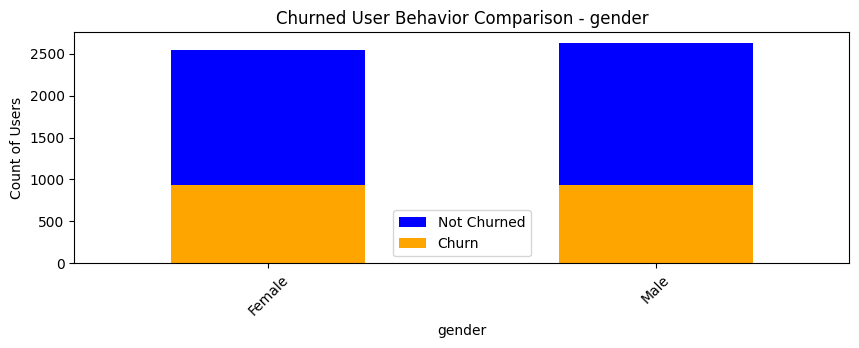

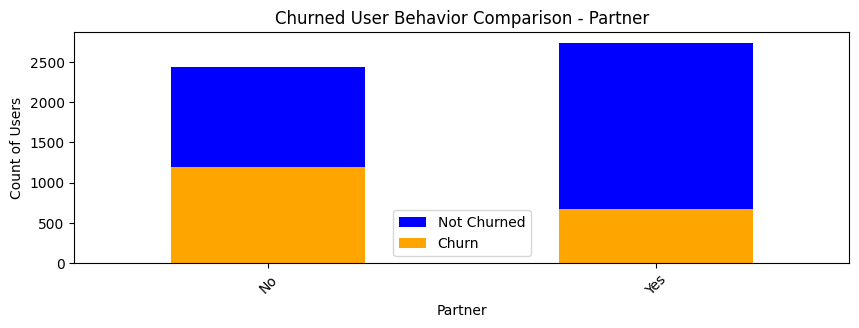

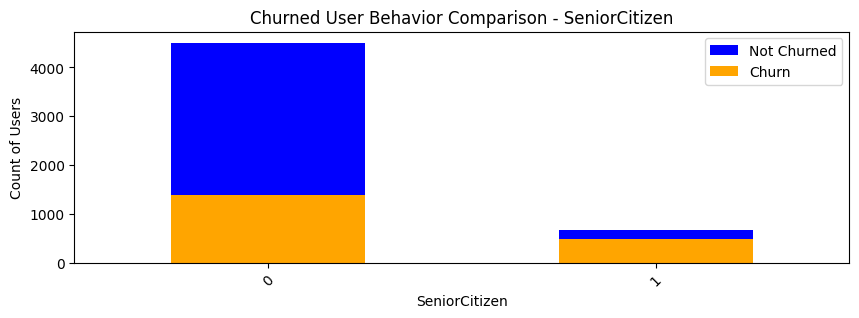

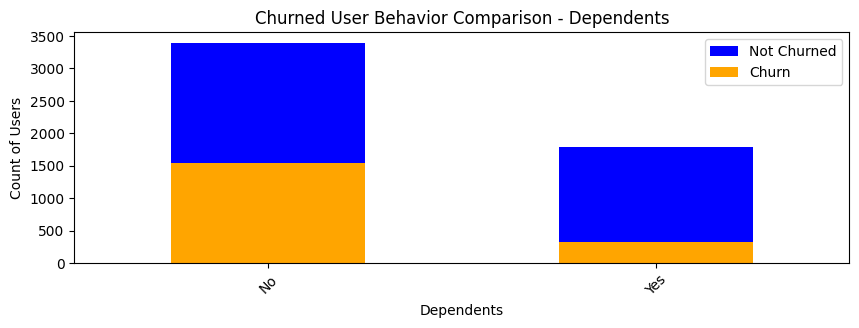

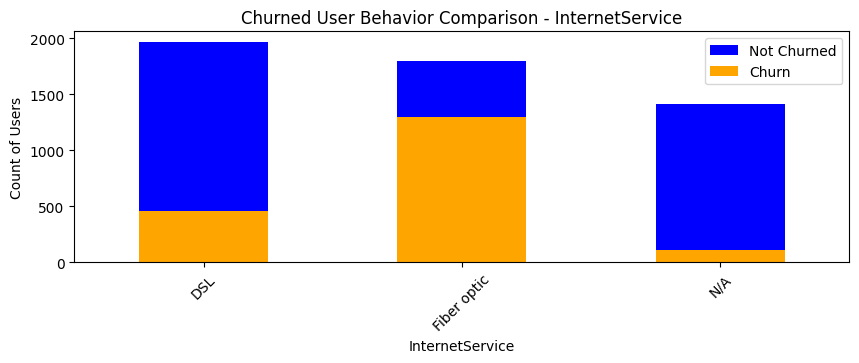

In [22]:
# Plot categorical fields
bar_plots(tele, categorical)

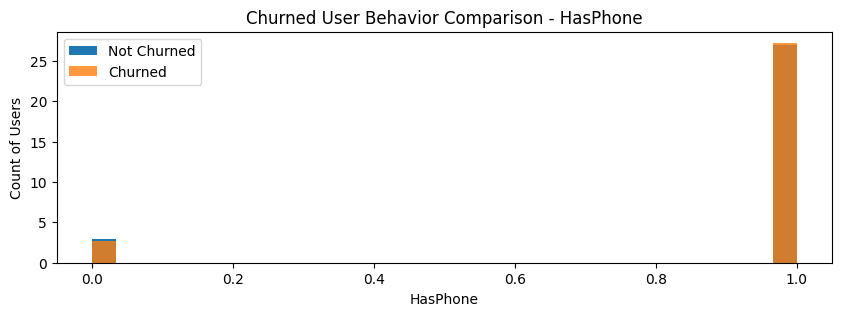

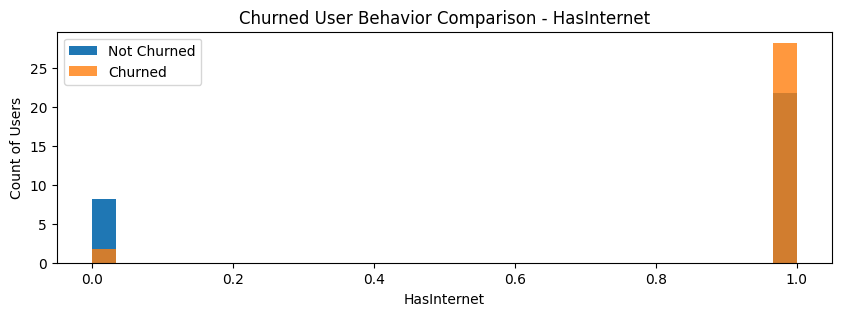

In [23]:
# Plot numerical fields
generate_histogram(tele, numerical)

# Combined Dataframe Exploratory Data Analysis

Users who churn are more likely to not have a partner, are not senior citizens, and do not have dependents compared to those who do not churn. Additionally, it appears that there is a higher likelihood of churn among customers who have internet access, particularly those who subscribe to the Fiber Optic service.

# Churn User Summary

- Our exploratory data analysis (EDA) provides a preliminary understanding of churned users.

- Compared to non-churned users, churned users are more likely to be single, not senior citizens, and not have dependents. Additionally, there appears to be a higher likelihood of churn among customers with internet access, particularly those using the Fiber Optic service.

- In contrast to non-churned users, churned users have higher monthly charges and a shorter duration of their Interconnect subscription. However, it’s important to note that Total Charges cannot be directly compared as they are a product of both monthly charges and the duration of the subscription.

- Furthermore, churned users are more likely to be on month-to-month contracts, use electronic checks as their payment method, and opt for paperless billing.

# Creating Training, Validation, and Test Data

Before training our models, we need to perform several crucial steps:

1. **Encode categorical fields:** This process converts categorical data into numerical values that the models can understand and use for prediction.

2. **Split the dataset into three data sets:** We divide the dataset into training, validation, and test sets. The training and validation sets are used to find the best hyperparameters for the model, while the test set is used to evaluate the model’s performance on unseen data.

3. **Scale certain fields:** If the numerical values in certain fields are too large, we need to scale them to a more manageable range. This helps prevent the model from placing too much weight on these values, which could be thousands of times larger than binary values like “senior citizen” (0/1).

# Drop Fields Not Required for Model Training

Not all fields in the dataset are necessary for model training. In this section, we will eliminate fields that could introduce noise or be irrelevant to generating the most accurate predictions.

In [24]:
# Create list of fields to drop
# Drop months_diff to avoid data leakage
fields_to_drop = ['customerID','BeginDate','EndDate','EndDate_New','months_diff']

# Create list of fields to drop
tele = tele.drop(columns=fields_to_drop)

# Check that fields were dropped
tele.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churned,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,HasPhone,HasInternet,start_day,start_month,start_year
0,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,N/A,0,1,2,1,2020
1,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1,1,5,4,2017
2,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,1,1,10,2019
3,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,N/A,0,1,6,5,2016
4,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,1,6,9,2019


# Encode Categorical Fields

Since the categorical fields that need to be preserved during the conversion to numerical values lack a ranking or order, we will employ One-Hot Encoding (OHE) instead of ordinal encoding.

In [25]:
# Create a list of the columns that need to be converted
categorical_columns = ['Type','PaperlessBilling','PaymentMethod','gender','Partner','Dependents','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines']

# Convert categorical fields to numerical fields using OHE
# Not removing dummy variables because the categorical fields are not binary (1/0)
tele_ohe = pd.get_dummies(tele, columns=categorical_columns, drop_first=False)

# Print sample of encoded data frame
tele_ohe.head()

,MonthlyCharges,TotalCharges,Churned,SeniorCitizen,HasPhone,HasInternet,start_day,start_month,start_year,Type_Month-to-month,Type_One year,Type_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_N/A,OnlineSecurity_N/A,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_N/A,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_N/A,DeviceProtection_No,DeviceProtection_Yes,TechSupport_N/A,TechSupport_No,TechSupport_Yes,StreamingTV_N/A,StreamingTV_No,StreamingTV_Yes,StreamingMovies_N/A,StreamingMovies_No,StreamingMovies_Yes,MultipleLines_N/A,MultipleLines_No,MultipleLines_Yes
0,29.85,29.85,0,0,0,1,2,1,2020,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
1,56.95,1889.50,0,0,1,1,5,4,2017,0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,53.85,108.15,1,0,1,1,1,10,2019,1,0,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
3,42.30,1840.75,0,0,0,1,6,5,2016,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0
4,70.70,151.65,1,0,1,1,6,9,2019,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0


# Split Data Into Training, Validation & Test Sets

Since hyperparameter tuning is required, we need to create a few sets of training data to fit and evaluate the model on.

In [26]:
# The validiation set will be split in half to get 3 datasets with a ration of 3:1:1
# Set Random State to 12345 to Replicate Training Set in Future
# 60% of data will be in training_set and other 40% will be in validation_set_to_split
training_set, validation_set_to_split = train_test_split(tele_ohe, test_size=0.40, random_state=12345)

# Split validation_set_to_split in half to create a validation and test set
validation_set, test_set = train_test_split(validation_set_to_split, test_size=0.50, random_state=12345)

# Create the features and target training datasets
features_train = training_set.drop(['Churned'], axis=1)
target_train = training_set['Churned']

# Create the features and target validation datasets
features_valid = validation_set.drop(['Churned'], axis=1)
target_valid = validation_set['Churned']

# Create the features and target test datasets
features_test = test_set.drop(['Churned'], axis=1)
target_test = test_set['Churned']

#Training 
print(features_train.shape) # Training set contains 60% of original dataframe rows 
print(target_train.shape)   # Training set contains 60% of original dataframe rows 

# Validation
print(features_valid.shape) # Validation set contains 25% of original dataframe rows 
print(target_valid.shape)   # Validation set contains 25% of original dataframe rows 

# Test
print(features_test.shape)  # Test set contains 25% of original dataframe rows 
print(target_test.shape)    # Test set contains 25% of original dataframe rows

(4225, 47)
(4225,)
(1409, 47)
(1409,)
(1409, 47)
(1409,)


# Performing Scalling

In [27]:
# Create a list of features that need to be scaled
# Scaling is needed because these values are much larger than 0/1 and we don't want the model to overfit for these features
features_to_scale = [ 'MonthlyCharges', 'TotalCharges', 'start_day','start_month', 'start_year']

# Fit StandardScaler to scale features for training set only
# Then apply the same scaler to transform all three sets (train, validation and test)
# The scaler is never fit using validation/test data
transformer = StandardScaler().fit(features_train[features_to_scale].to_numpy())

# Create a copy of df with scaled/transformed features 
# Apply the same scaler to transform all three sets (train, validation and test) using transformer

# Train
features_train_scaled = features_train.copy()
features_train_scaled.loc[:, features_to_scale] = transformer.transform(features_train[features_to_scale].to_numpy())

# Validation
features_valid_scaled = features_valid.copy()
features_valid_scaled.loc[:, features_to_scale] = transformer.transform(features_valid[features_to_scale].to_numpy())

# Test
features_test_scaled = features_test.copy()
features_test_scaled.loc[:, features_to_scale] = transformer.transform(features_test[features_to_scale].to_numpy())

# Print sample of scaled trained dataset
print('Train')
display(features_train_scaled.head())

print('Validation')
display(features_valid_scaled.head())

print('Test')
display(features_test_scaled.head())

Train


,MonthlyCharges,TotalCharges,SeniorCitizen,HasPhone,HasInternet,start_day,start_month,start_year,Type_Month-to-month,Type_One year,Type_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_N/A,OnlineSecurity_N/A,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_N/A,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_N/A,DeviceProtection_No,DeviceProtection_Yes,TechSupport_N/A,TechSupport_No,TechSupport_Yes,StreamingTV_N/A,StreamingTV_No,StreamingTV_Yes,StreamingMovies_N/A,StreamingMovies_No,StreamingMovies_Yes,MultipleLines_N/A,MultipleLines_No,MultipleLines_Yes
836,0.219283,0.966129,0,1,1,-1.606107,1.561811,-1.450172,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0
1005,1.028885,1.200041,1,1,1,-1.106306,0.726433,-0.940398,0,1,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1
4220,-1.499261,-0.564376,0,1,0,-0.606505,0.169514,-0.940398,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
6543,-0.332042,0.496512,0,1,1,-1.606107,1.561811,-1.450172,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0
272,-1.323764,-1.007282,0,0,1,0.393098,1.283352,1.098699,1,0,0,1,0,1,0,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0


Validation


,MonthlyCharges,TotalCharges,SeniorCitizen,HasPhone,HasInternet,start_day,start_month,start_year,Type_Month-to-month,Type_One year,Type_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_N/A,OnlineSecurity_N/A,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_N/A,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_N/A,DeviceProtection_No,DeviceProtection_Yes,TechSupport_N/A,TechSupport_No,TechSupport_Yes,StreamingTV_N/A,StreamingTV_No,StreamingTV_Yes,StreamingMovies_N/A,StreamingMovies_No,StreamingMovies_Yes,MultipleLines_N/A,MultipleLines_No,MultipleLines_Yes
4164,1.527230,2.485357,0,1,1,0.892900,-1.222783,-1.450172,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
4068,-1.499261,-0.897965,0,1,0,0.892900,1.561811,0.588925,0,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
6842,-1.484360,-0.904599,0,1,0,-1.106306,-1.501242,1.098699,0,1,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
914,-1.310519,-0.222738,0,1,0,0.892900,-1.222783,-1.450172,0,0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
6877,0.162991,-0.987427,0,1,1,1.392701,1.561811,1.098699,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0


Test


,MonthlyCharges,TotalCharges,SeniorCitizen,HasPhone,HasInternet,start_day,start_month,start_year,Type_Month-to-month,Type_One year,Type_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_N/A,OnlineSecurity_N/A,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_N/A,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_N/A,DeviceProtection_No,DeviceProtection_Yes,TechSupport_N/A,TechSupport_No,TechSupport_Yes,StreamingTV_N/A,StreamingTV_No,StreamingTV_Yes,StreamingMovies_N/A,StreamingMovies_No,StreamingMovies_Yes,MultipleLines_N/A,MultipleLines_No,MultipleLines_Yes
6085,-0.467804,-0.951341,0,1,1,-0.106703,0.447974,1.098699,1,0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
6373,0.932859,0.804983,0,1,1,-0.606505,-0.108945,-0.430623,1,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0
1488,-0.447936,-0.995586,0,1,1,-0.606505,-1.501242,1.608473,1,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
703,-1.464492,-1.003391,0,1,0,1.392701,1.561811,1.098699,1,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
3572,0.487494,0.160269,1,1,1,-0.106703,-0.108945,0.079151,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0


# Print the shape of the training sets.

In [28]:
print('Training')
features_train = features_train_scaled.reset_index(drop = True)
target_train = target_train.reset_index(drop = True)
print('Training Features:', features_train.shape)
print('Training Target:', target_train.shape)

print()
print('Validation')
features_valid = features_valid_scaled.reset_index(drop = True)
target_valid = target_valid.reset_index(drop = True)
print('Validation Features:', features_valid.shape)
print('Validation Target:', target_valid.shape)

print()
print('Test')
features_test = features_test_scaled.reset_index(drop = True)
target_test = target_test.reset_index(drop = True)
print('Test Features:', features_test.shape)
print('Test Target:', target_test.shape)

Training
Training Features: (4225, 47)
Training Target: (4225,)

Validation
Validation Features: (1409, 47)
Validation Target: (1409,)

Test
Test Features: (1409, 47)
Test Target: (1409,)


# Modeling and Evaluation:

For the modeling and evaluation section, please note the following:

- Model performance will be evaluated using AUC_ROC and Accuracy metrics.

- For the RandomForest, LightGBM, CatBoost, and XGBoost models, I will tune them to find the optimal n_estimators and depth using GridSearchCV.

- The DummyClassifier and LogisticRegression models will serve as a baseline for comparison with other classification models. We won’t be tuning these models.

- In the following section, I will provide a table of model timings and results to help me select a model and evaluate its performance on the test data.

# The DummyClassifier Baseline Model

The DummyClassifier model will serve as a baseline for comparison with other classification models.

In [29]:
%%time

# Create a baseline random classifier
model = DummyClassifier(strategy='stratified', random_state=1234)

# Fit the classifier on the training data
model.fit(features_train, target_train)

# Make predictions on the validation features
prediction_valid = model.predict(features_valid)

# Calculate accuracy and other metrics
accuracy = accuracy_score(target_valid, prediction_valid)
report = classification_report(target_valid, prediction_valid)

# Calculate and Print AUC_ROC Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('The AUC_ROC Score is on Validation Set:',round(auc_roc,3))

# Print the results
print("Accuracy on Validation Set:", round(accuracy,3))
print()

print("Classification Report:")
print(report)

The AUC_ROC Score is on Validation Set: 0.522
Accuracy on Validation Set: 0.623

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1027
           1       0.30      0.30      0.30       382

    accuracy                           0.62      1409
   macro avg       0.52      0.52      0.52      1409
weighted avg       0.62      0.62      0.62      1409

CPU times: user 8.26 ms, sys: 21 µs, total: 8.28 ms
Wall time: 7.55 ms


# LogisticRegression Model

In [30]:
%%time

# Create a LogisticRegression Model
model = LogisticRegression(random_state=12345, solver="liblinear")

# Fit the model to the traning dataset
model.fit(features_train, target_train)

# Make predictions on the validation features
prediction_valid = model.predict(features_valid)

# Calculate accuracy and other metrics
accuracy = accuracy_score(target_valid, prediction_valid)
report = classification_report(target_valid, prediction_valid)

# Calculate and Print AUC_ROC Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('The AUC_ROC Score is on Validation Set:',round(auc_roc,3))

# Print the results
print("Accuracy on Validation Set:", round(accuracy,3))
print()

print("Classification Report:")
print(report)

The AUC_ROC Score is on Validation Set: 0.851
Accuracy on Validation Set: 0.803

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1027
           1       0.67      0.54      0.60       382

    accuracy                           0.80      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

CPU times: user 38.8 ms, sys: 24.1 ms, total: 62.9 ms
Wall time: 70.7 ms


# Model Evaluation Function

In this section, I’ve developed a function that accepts a model and its name as input and returns the following:

- The time taken to find the optimal hyperparameters using the training dataset, including the time required to predict the target values on the validation dataset.
- The best hyperparameters that resulted in the highest AUC_ROC score on the training dataset.
- The AUC_ROC score on the training dataset.
- The AUC_ROC score on the validation dataset, using the hyperparameters found during the tuning process.


This function will help me avoid code duplication and ensure that all models are trained using the same search space, allowing for fair comparison. In the subsequent sections, I’ll input the names of the models into this function to obtain their timings and values. After tuning all models, I’ll compare these values and timings to select the most suitable model for predicting test targets.

In [31]:
# Create model evaluation function 
# For model tuning, we will use GridSearchCV and keep the search space constant across models
def model_evaluation(model,model_name):
    
    # Create a search space to optimize for best combination of n_estimators and max_depth
    search_space = {'n_estimators': [5,10,25,50]
                    , 'max_depth': [5,10,25,50]}
       
    # Initialize Model
    model = model
    
    # Create list of scoring/evaluation metrics
    scoring = ['accuracy','roc_auc']
    
    # Create a GridSearchCV Object
    # Use 3-fold cross validation (5 is the default, but to save time on training, we will use 3-fold)
    # Select Best Model Using roc_auc as Scorer function 
    model_grid = GridSearchCV(model, param_grid = search_space, cv = 5, scoring = 'roc_auc', refit = 'roc_auc', verbose = 0)

    # Fit model to training data
    model_grid.fit(features_train, target_train)

    # Save best parameters to variable that produce the smallest AUC_ROC
    # best_parameters will contain a dictionary of the best parameters that produced the lowest AUC_ROC
    best_parameters = model_grid.best_params_

    # Best score is the AUC_ROC value on the training data
    best_score = model_grid.best_score_

    # Best grid will contain the parameters that can be used to predict values on the validation set
    # The refitted estimator is made available at the best_estimator_ attribute and permits using predict directly on this GridSearchCV instance
    best_grid = model_grid.best_estimator_

    # Predict target values on the validation set
    predicted_values = best_grid.predict(features_valid)
    
    # Calculate and Print AUC_ROC Score
    probabilities_valid = best_grid.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('The AUC_ROC Score is',round(auc_roc,2))
    
    # Calculate accuracy between predicted target and actual target for validation set
    accuracy = accuracy_score(target_valid, predicted_values)

    # Print results of tuning and AUC_ROC & Accuracy on validation set 
    print("Best Parameters For", model_name,":", best_parameters )
    print("These Parameters Produced a Best AUC_ROC Score of", round(best_score,2), "on the Training Data")
    print()
    print("The AUC_ROC Using the Tuned", model_name, "on the Validation Set:", round(auc_roc,3))
    print("The Accuracy Using the Tuned", model_name, "on the Validation Set:",round(accuracy,3))
    print()
    print('Hyperparameter Tuning, Training, & Prediction Time for', model_name,':')

# RandomForestClassifier

In [32]:
%%time

# Set variables to RandomForestClassifier
model = RandomForestClassifier(random_state=12345)
model_name = 'RandomForestClassifier'

# Configure model_evaluation to use RandomForestClassifier
model_evaluation(model, model_name)

The AUC_ROC Score is 0.88
Best Parameters For RandomForestClassifier : {'max_depth': 10, 'n_estimators': 50}
These Parameters Produced a Best AUC_ROC Score of 0.87 on the Training Data

The AUC_ROC Using the Tuned RandomForestClassifier on the Validation Set: 0.88
The Accuracy Using the Tuned RandomForestClassifier on the Validation Set: 0.828

Hyperparameter Tuning, Training, & Prediction Time for RandomForestClassifier :
CPU times: user 4.95 s, sys: 44.5 ms, total: 5 s
Wall time: 5.03 s


# LGBMClassifier

In [33]:
%%time

# Set variables to LGBMClassifier
model = LGBMClassifier(random_state=12345)
model_name = 'LGBMClassifier'

# Configure model_evaluation to use LGBMRegressor
model_evaluation(model, model_name)

The AUC_ROC Score is 0.91
Best Parameters For LGBMClassifier : {'max_depth': 10, 'n_estimators': 50}
These Parameters Produced a Best AUC_ROC Score of 0.9 on the Training Data

The AUC_ROC Using the Tuned LGBMClassifier on the Validation Set: 0.905
The Accuracy Using the Tuned LGBMClassifier on the Validation Set: 0.854

Hyperparameter Tuning, Training, & Prediction Time for LGBMClassifier :
CPU times: user 10.5 s, sys: 169 ms, total: 10.6 s
Wall time: 10.7 s


# CatBoostClassifier

In [34]:
%%time

# Set variables to CatBoostClassifier
model = CatBoostClassifier(random_state=12345, verbose=0)
model_name = 'CatBoostClassifier'

# Configure model_evaluation to use CatBoostClassifier
model_evaluation(model, model_name)

The AUC_ROC Score is 0.87
Best Parameters For CatBoostClassifier : {'max_depth': 5, 'n_estimators': 5}
These Parameters Produced a Best AUC_ROC Score of 0.87 on the Training Data

The AUC_ROC Using the Tuned CatBoostClassifier on the Validation Set: 0.875
The Accuracy Using the Tuned CatBoostClassifier on the Validation Set: 0.814

Hyperparameter Tuning, Training, & Prediction Time for CatBoostClassifier :
CPU times: user 13.3 s, sys: 79.5 ms, total: 13.4 s
Wall time: 17.7 s


# XGBClassifier

In [38]:
%%time

# Set variables to XGBClassifier
model = XGBClassifier(random_state=12345, verbosity = 0)
model_name = 'XGBClassifier'

# Configure model_evaluation to use XGBClassifier
model_evaluation(model, model_name)

The AUC_ROC Score is 0.92
Best Parameters For XGBClassifier : {'max_depth': 5, 'n_estimators': 50}
These Parameters Produced a Best AUC_ROC Score of 0.9 on the Training Data

The AUC_ROC Using the Tuned XGBClassifier on the Validation Set: 0.916
The Accuracy Using the Tuned XGBClassifier on the Validation Set: 0.869

Hyperparameter Tuning, Training, & Prediction Time for XGBClassifier :
CPU times: user 1min 10s, sys: 204 ms, total: 1min 10s
Wall time: 1min 10s


Interconnect aims to forecast its client churn. After training several models on the training data and predicting validation set targets, the XGBClassifier model emerged as the best performer, with an AUC_ROC of 0.916 and an accuracy of 0.869. In the subsequent section, I will evaluate the CatBoostClassifier’s ability to predict test targets using the optimal hyperparameters identified during training. I will assess model performance using AUC_ROC and accuracy scores. For Interconnect to accept this work, the model’s AUC_ROC must exceed 0.85.

# Evaluate AUC_ROC & Accuracy For Predicting Test Targets

Using the results from the previous section, I will select the models with the highest AUC_ROC and predict the test values using the optimal hyperparameters.

# XGBClassifier - Test Data Evaluation

Predict test targets using a decision tree with a maximum depth of 5 and 50 estimators. Evaluate the predictions using the AUC-ROC and accuracy scores.

In [39]:
%%time 

# Initialize Model
# Use hyperparameters from tuning
model = XGBClassifier(random_state=12345, n_estimators = 50, max_depth = 5)

# Fit model to training data
model.fit(features_train, target_train)

# Predict target values on the test set
predicted_values = model.predict(features_test)

# Calculate and Print AUC_ROC Score
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

# Calculate accuracy between predicted target and actual target for validation set
accuracy = accuracy_score(target_test, predicted_values)

# Print results of tuning and AUC_ROC & Accuracy on test set 
print("The AUC_ROC Using the Tuned XGBClassifier model on the Test Set:", round(auc_roc,3))
print("The Accuracy Using the Tuned XGBClassifier model on the Test Set:",round(accuracy,3))
print()
print('Prediction Time:')

The AUC_ROC Using the Tuned XGBClassifier model on the Test Set: 0.901
The Accuracy Using the Tuned XGBClassifier model on the Test Set: 0.861

Prediction Time:
CPU times: user 899 ms, sys: 74 µs, total: 899 ms
Wall time: 898 ms


# Conlcusion

The XGBClassifier, with an AUC_ROC score of 0.901 and an accuracy score of 0.861, is an excellent choice for Interconnect to implement for predicting churn. Its accurate and fast predictions make it a great fit for the task. While XGBClassifier achieves the highest AUC_ROC, other models like the LGBMClassifier and RandomForestClassifier also produce high accuracy scores and AUC_ROC. However, the hyperparameter tuning time for these models was significantly shorter, around 10 seconds, compared to XGBClassifier’s over a minute. If Interconnect prioritizes faster tuning and prediction times, these models should be considered. Nevertheless, for our specific use case, the XGBClassifier’s combination of high accuracy and AUC_ROC scores makes it the most suitable choice.

Compared to users who haven’t churned, churned users have higher monthly charges and stay with Interconnect for a shorter duration. However, it’s not possible to draw conclusions about Total Charges because it’s a product of monthly charges and the duration spent with Interconnect. Compared to users who haven’t churned, churned users are more likely to be on month-to-month contracts, use electronic checks as their payment method, and opt for paperless billing. Users who churn are more likely to not have a partner, are not senior citizens, and do not have dependents compared to those who do not churn. Additionally, it appears that there is a higher likelihood of churn among customers who have internet access, particularly those who subscribe to the Fiber Optic service.